In [1]:
import numpy as np
import matplotlib.pyplot as plt
np.set_printoptions(precision=2)

In [2]:
# read data
elev_map = np.load('./data/elev_map0.npy')
dynamic_pc = np.load('./data/dynamic_pc0.npy')
robot_pose = np.load('./data/robot_pose0.npy')
# elev_map = dynamic_pc

X = elev_map[:,0]
Y = elev_map[:,1]
Z = elev_map[:,2]
rgb = elev_map[:,3]

print('Robot pose:', robot_pose)
print('Z_min:', np.min(Z), 'Z_max:', np.max(Z))

Robot pose: [9.46 4.04 0.11]
Z_min: -0.057979509234428406 Z_max: 0.8241029977798462


8.687656727272957e-39 2.1170518230205614e-38


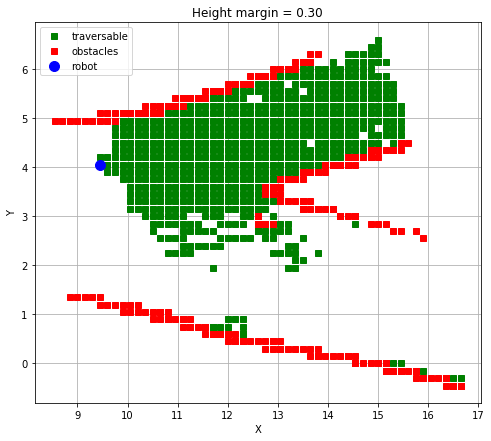

In [3]:
# define traversable height margin
margin = 0.3
print(np.mean(rgb[Z<=margin]), np.mean(rgb[Z>margin]))

plt.figure(figsize=(int(np.max(X)-np.min(X)), int(np.max(Y)-np.min(Y))))
plt.plot(X[Z<=margin], Y[Z<=margin], 's', color='green', label='traversable')
plt.plot(X[Z>margin], Y[Z>margin], 's', color='red', label='obstacles')
plt.plot(robot_pose[0], robot_pose[1], 'ro', color='b', markersize=10, label='robot')

plt.title('Height margin = %.2f'%margin)
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.grid()

### Create occupancy grid

In [4]:
def create_grid(elev_map, map_res=0.15, safety_distance=0., margin=0.3):
    # minimum and maximum north coordinates
    y_min = np.min(elev_map[:, 1])
    y_max = np.max(elev_map[:, 1])

    # minimum and maximum east coordinates
    x_min = np.min(elev_map[:, 0])
    x_max = np.max(elev_map[:, 0])

    # given the minimum and maximum coordinates we can
    # calculate the size of the grid.
    y_size = int((y_max - y_min)//map_res)
    x_size = int((x_max - x_min)//map_res)

    # Initialize an unexplored grid
    # unexplored: 0.5
    # free:        0
    # occupied:    1
    grid = np.zeros((x_size, y_size)) + 0.5
    elev_grid  = np.full((x_size, y_size), np.nan)

    # Populate the grid with obstacles
    for i in range(elev_map.shape[0]):
        x, y, z, _ = elev_map[i, :]
        dx, dy, dz = map_res, map_res, map_res
        sd = safety_distance * (z > margin) # safety distance is added to points treated as obstacles
        obstacle = [
            int(np.clip((x - dx - sd - x_min)//dx, 0, x_size-1)),
            int(np.clip((x + dx + sd - x_min)//dx, 0, x_size-1)),
            int(np.clip((y - dy - sd - y_min)//dy, 0, y_size-1)),
            int(np.clip((y + dy + sd - y_min)//dy, 0, y_size-1)),
        ]
        grid[obstacle[0]:obstacle[1]+1, obstacle[2]:obstacle[3]+1] = z > margin
        elev_grid[obstacle[0]:obstacle[1]+1, obstacle[2]:obstacle[3]+1] = z
    return grid, elev_grid

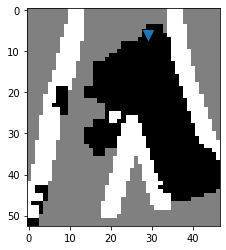

In [5]:
# minimum and maximum east coordinates
x_min = np.min(elev_map[:, 0])
x_max = np.max(elev_map[:, 0])
# minimum and maximum north coordinates
y_min = np.min(elev_map[:, 1])
y_max = np.max(elev_map[:, 1])
map_res = 0.15

grid, elev_grid = create_grid(elev_map, map_res, safety_distance=0.1)
robot_grid_pose = (robot_pose - [x_min, y_min, 0]) // map_res

plt.imshow(grid, cmap='gray')
plt.plot(robot_grid_pose[1], robot_grid_pose[0], 'v', markersize=10)

### A* planning on a grid

In [6]:
from queue import PriorityQueue
from enum import Enum

In [7]:
class Action(Enum):
    """
    An action is represented by a 3 element tuple.
    
    The first 2 values are the delta of the action relative
    to the current grid position. The third and final value
    is the cost of performing the action.
    """
    LEFT = (0, -1, 1)
    RIGHT = (0, 1, 1)
    UP = (-1, 0, 1)
    DOWN = (1, 0, 1)
    LEFT_UP = (-1, -1, np.sqrt(2))
    LEFT_DOWN = (1, -1, np.sqrt(2))
    RIGHT_UP = (-1, 1, np.sqrt(2))
    RIGHT_DOWN = (1, 1, np.sqrt(2))
    
    @property
    def cost(self):
        return self.value[2]
    
    @property
    def delta(self):
        return (self.value[0], self.value[1])
            
    
def valid_actions(grid, current_node):
    """
    Returns a list of valid actions given a grid and current node.
    """
    valid = list(Action)
    n, m = grid.shape[0] - 1, grid.shape[1] - 1
    x, y = current_node
    
    # check if the node is off the grid or
    # it's an obstacle
    
    if x - 1 < 0 or grid[x-1, y] == 1:
        valid.remove(Action.UP)
    if x + 1 > n or grid[x+1, y] == 1:
        valid.remove(Action.DOWN)
    if y - 1 < 0 or grid[x, y-1] == 1:
        valid.remove(Action.LEFT)
    if y + 1 > m or grid[x, y+1] == 1:
        valid.remove(Action.RIGHT)
        
    if (x - 1 < 0 or y - 1 < 0) or grid[x - 1, y - 1] == 1:
        valid.remove(Action.LEFT_UP)
    if (x - 1 < 0 or y + 1 > m) or grid[x - 1, y + 1] == 1:
        valid.remove(Action.RIGHT_UP)
    if (x + 1 > n or y - 1 < 0) or grid[x + 1, y - 1] == 1:
        valid.remove(Action.LEFT_DOWN)
    if (x + 1 > n or y + 1 > m) or grid[x + 1, y + 1] == 1:
        valid.remove(Action.RIGHT_DOWN)
        
    return valid

In [8]:
def heuristic(p, goal, mode='euclid'):
    p = np.array(p); goal = np.array(goal)
    if mode=='euclid':
        h = np.sqrt( (p[0] - goal[0])**2 + (p[1]-goal[1])**2 )
    elif mode=='manhattan':
        h = np.abs(p[0] - goal[0]) + np.abs(p[1]-goal[1])
    else:
        h = np.linalg.norm(p - goal)
    return h

In [9]:
def a_star(grid, h, start, goal):

    path = []
    path_cost = 0
    queue = PriorityQueue()
    queue.put((0, start))
    visited = set(start)

    branch = {}
    found = False
    while not queue.empty():
        item = queue.get()
        current_node = item[1]

        if current_node == start:
            current_cost = 0.0
        else:              
            current_cost = branch[current_node][0]
            
        if current_node == goal:        
            print('Found a path.')
            found = True
            break
        else:
            for action in valid_actions(grid, current_node):
                # get the tuple representation
                da = action.delta
                next_node = (current_node[0] + da[0], current_node[1] + da[1])
                branch_cost = current_cost + action.cost
                queue_cost = branch_cost + h(next_node, goal)
                
                if next_node not in visited:                
                    visited.add(next_node)               
                    branch[next_node] = (branch_cost, current_node, action)
                    queue.put((queue_cost, next_node))
             
    if found:
        # retrace steps
        n = goal
        path_cost = branch[n][0]
        path.append(goal)
        while branch[n][1] != start:
            path.append(branch[n][1])
            n = branch[n][1]
        path.append(branch[n][1])
    else:
        print('**********************')
        print('Failed to find a path!')
        print('**********************') 
    return path[::-1], path_cost

Found a path.


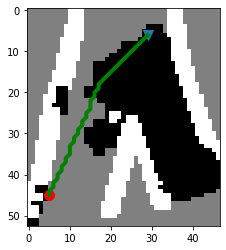

In [10]:
start_grid = (int(robot_grid_pose[0]), int(robot_grid_pose[1]))
# choose random goal location
while True:
    i,j = np.random.randint(0, grid.shape[0]), np.random.randint(0, grid.shape[1])
    if grid[i,j] != 1:
        goal_grid = (i,j)
        break

path_grid, cost = a_star(grid, heuristic, start_grid, goal_grid)

pp = np.array(path_grid)
plt.imshow(grid, cmap='gray')
plt.plot(start_grid[1], start_grid[0], 'v', markersize=10)
plt.plot(goal_grid[1], goal_grid[0], 'ro', markersize=10)
if len(path_grid)>0: plt.plot(pp[:, 1], pp[:, 0], 'g', linewidth=4)

### Transform path to map coordinates

In [11]:
path = [(np.array(point)*0.15+[x_min, y_min]).tolist()+[elev_grid[point]] for point in path_grid]
path = np.array(path)

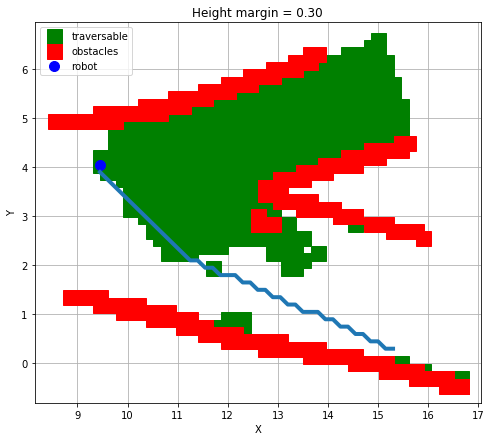

In [12]:
plt.figure(figsize=(int(np.max(X)-np.min(X)), int(np.max(Y)-np.min(Y))))
plt.plot(X[Z<=margin], Y[Z<=margin], 's', color='green', label='traversable', markersize=15)
plt.plot(X[Z>margin], Y[Z>margin], 's', color='red', label='obstacles', markersize=15)
plt.plot(robot_pose[0], robot_pose[1], 'ro', color='b', markersize=10, label='robot')
if len(path)>0: plt.plot(path[:,0], path[:,1], linewidth=4)

plt.title('Height margin = %.2f'%margin)
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.grid()

### Path prunning and smoothing

In [13]:
def point(p):
    return np.array([p[0], p[1], 1.]).reshape(1, -1)

def collinearity_check(p1, p2, p3, epsilon=1e-6):
    m = np.concatenate((p1, p2, p3), 0)
    det = np.linalg.det(m)
    return abs(det) < epsilon
# using collinearity check here
def prune_path(path, eps=1e-6):
    pruned_path = path  
    i = 0
    while i < len(pruned_path) - 2:
        p1 = point(pruned_path[i])
        p2 = point(pruned_path[i+1])
        p3 = point(pruned_path[i+2])
        # If the 3 points are in a line remove
        # the 2nd point.
        # The 3rd point now becomes and 2nd point
        # and the check is redone with a new third point
        # on the next iteration.
        if collinearity_check(p1, p2, p3, eps):
            # Something subtle here but we can mutate
            # `pruned_path` freely because the length
            # of the list is check on every iteration.
            pruned_path.remove(pruned_path[i+1])
        else:
            i += 1
    return np.array(pruned_path)

In [14]:
from scipy import interpolate

def smooth_path(path, vis=False):
    x, y = zip(*path[:,:2])
    #create spline function
    f, u = interpolate.splprep([x, y], s=0)
    #create interpolated lists of points
    xint, yint = interpolate.splev(np.linspace(0, 1, 50), f)
    if vis:
        plt.scatter(x, y)
        plt.plot(xint, yint)
    return np.vstack([xint, yint]).T

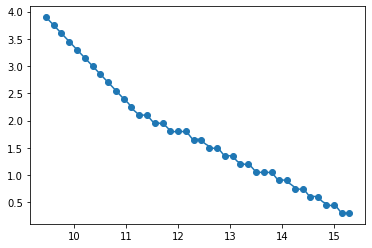

In [15]:
path_smoothed = smooth_path(path, vis=True)

### Put it all together

In [16]:
import time
tic = time.time()
grid, elev_grid = create_grid(elev_map, map_res=0.15, safety_distance=0.1)

# define start on a grid
robot_grid_pose = (robot_pose - [np.min(elev_map[:, 0]), np.min(elev_map[:, 1]), 0]) // map_res
start_grid = (int(robot_grid_pose[0]), int(robot_grid_pose[1]))
# choose random goal location
while True:
    i,j = np.random.randint(0, grid.shape[0]), np.random.randint(0, grid.shape[1])
    if grid[i,j] != 1:
        goal_grid = (i,j)
        break

path_grid, _ = a_star(grid, heuristic, start_grid, goal_grid)
# transform path to map coordintes (m)
path = [(np.array(point)*0.15+[x_min, y_min]).tolist()+[elev_grid[point]] for point in path_grid]
if len(path)>0:
    #path = prune_path(path, 1e-6)
    path = smooth_path(np.array(path), vis=0)
print('Path planning took {} sec'.format(time.time()-tic))

Found a path.
Path planning took 0.1253194808959961 sec


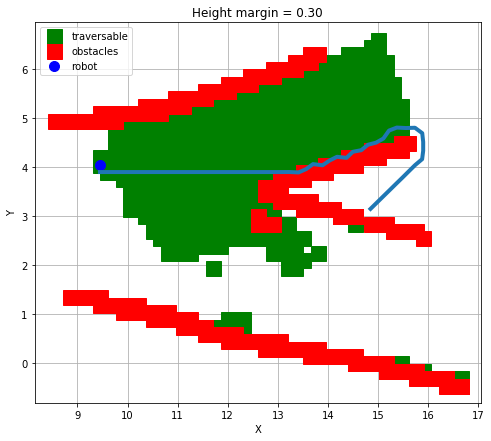

In [17]:
# visualize everithing
plt.figure(figsize=(int(np.max(X)-np.min(X)), int(np.max(Y)-np.min(Y))))
plt.plot(X[Z<=margin], Y[Z<=margin], 's', color='green', label='traversable', markersize=15)
plt.plot(X[Z>margin], Y[Z>margin], 's', color='red', label='obstacles', markersize=15)
plt.plot(robot_pose[0], robot_pose[1], 'ro', color='b', markersize=10, label='robot')
plt.plot(path[:,0], path[:,1], linewidth=4)

plt.title('Height margin = %.2f'%margin)
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.grid()

### Breadth First Search to find nearest frontier to plan to

In [18]:
from queue import Queue

def breadth_first_search(grid, start, unexplored_value=0.5):
    q = Queue(); q.put(start)
    visited = set(); visited.add(start)
    branch = {}
    found = False
    
    # Run loop while queue is not empty
    while not q.empty():
        # get element from the queue
        current_node = q.get()
        # if exploration is reached a frontier
        if grid[current_node[0], current_node[1]] == unexplored_value:
            print('Found a frontier.')
            goal = current_node
            found = True
            break
        else:
            # Iterate through each of the new nodes and:
            # If the node has not been visited you will need to
            # 1. Mark it as visited
            # 2. Add it to the queue
            # 3. Add how you got there to the branch dictionary
            valid = valid_actions(grid, current_node)
            for action in valid:
                # delta of performing the action
                da = action.value
                next_node = (current_node[0] + da[0], current_node[1] + da[1])
                # Check if the new node has been visited before.
                # If the node has not been visited you will need to
                # 1. Mark it as visited
                # 2. Add it to the queue
                # 3. Add how you got there to branch
                if next_node not in visited:                
                    visited.add(next_node)               
                    q.put(next_node)          
                    branch[next_node] = (current_node, action) 
    # Now, if you found a path, retrace your steps through 
    # the branch dictionary to find out how you got there!
    path = []
    if found and len(branch)>0:
        # retrace steps
        path = []
        n = goal
        while branch[n][0] != start:
            path.append(branch[n][0])
            n = branch[n][0]
        path.append(branch[n][0])
            
    return path[::-1], goal

Found a frontier.


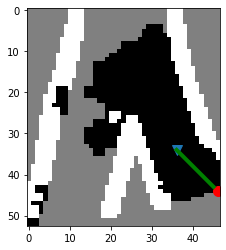

In [19]:
# start_grid = (int(robot_grid_pose[0]), int(robot_grid_pose[1]))
# choose random start location
while True:
    i,j = np.random.randint(0, grid.shape[0]), np.random.randint(0, grid.shape[1])
    if grid[i,j] != 1 and grid[i,j] != 0.5:
        start_grid = (i,j)
        break

path_grid, goal_grid = breadth_first_search(grid, start_grid)

pp = np.array(path_grid)
plt.imshow(grid, cmap='gray')
plt.plot(start_grid[1], start_grid[0], 'v', markersize=10)
plt.plot(goal_grid[1], goal_grid[0], 'ro', markersize=10)
if len(path_grid)>0: plt.plot(pp[:, 1], pp[:, 0], 'g', linewidth=4)

In [20]:
path = [(np.array(point)*0.15+[x_min, y_min]).tolist()+[elev_grid[point]] for point in path_grid]
path = np.array(path)

### Try different configurations

Found a frontier.
Path planning took 0.11578249931335449 sec


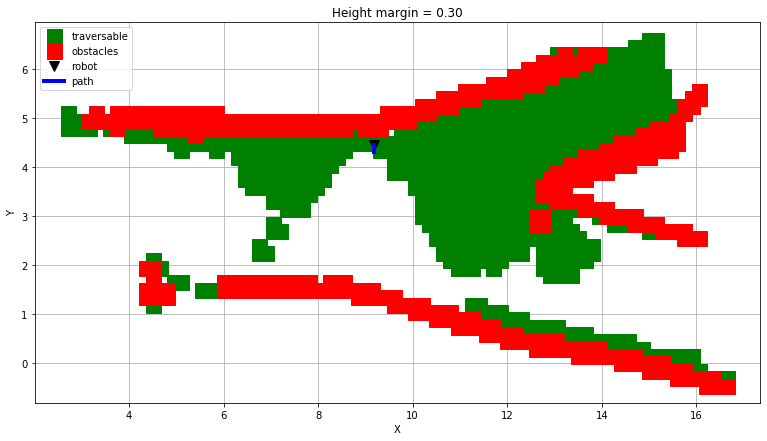

Found a frontier.
Path planning took 0.2057657241821289 sec


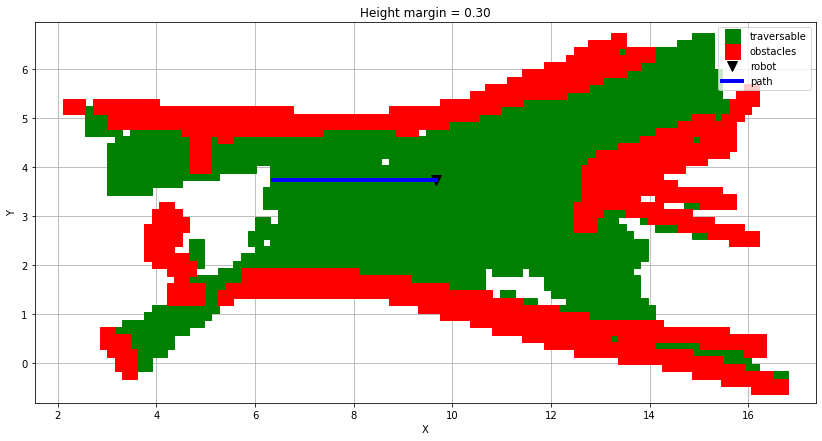

Found a frontier.
Path planning took 0.22708868980407715 sec


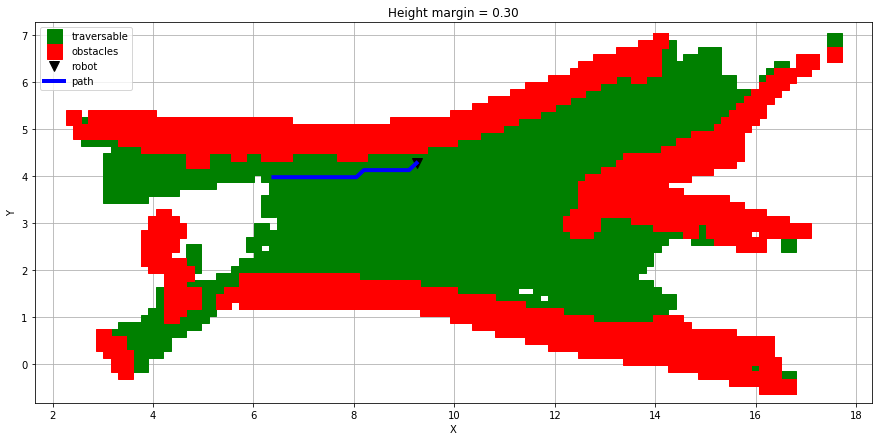

In [21]:
for ind in range(6, 9):
    # read data
    elev_map = np.load('./data/elev_map{}.npy'.format(ind))
    dynamic_pc = np.load('./data/dynamic_pc{}.npy'.format(ind))
    robot_pose = np.load('./data/robot_pose{}.npy'.format(ind))
    # elev_map = dynamic_pc

    tic = time.time()
    grid, elev_grid = create_grid(elev_map, map_res=0.15, safety_distance=0.2, margin=margin)
    x_min, y_min = np.min(elev_map[:, 0]), np.min(elev_map[:, 1])

    # define start on a grid
    robot_grid_pose = (robot_pose - [x_min, y_min, 0]) // map_res
    start_grid = (int(robot_grid_pose[0]), int(robot_grid_pose[1]))

    path_grid, goal_grid = breadth_first_search(grid, start_grid)
    # transform path to map coordintes (m)
    path = [(np.array(point)*0.15+[x_min, y_min]).tolist()+[elev_grid[point]] for point in path_grid]
    if len(path)>0:
        path = prune_path(path, 1e-3)
    #     path = smooth_path(np.array(path), vis=1)
    path = np.array(path) - path[0,:] + robot_pose # start path exactly from robot location
    print('Path planning took {} sec'.format(time.time()-tic))
    
    # visualize everithing
    X = elev_map[:,0]; Y = elev_map[:,1]; Z = elev_map[:,2]
    plt.figure(figsize=(int(np.max(X)-np.min(X)), int(np.max(Y)-np.min(Y))))
    plt.plot(X[Z<=margin], Y[Z<=margin], 's', color='green', label='traversable', markersize=15)
    plt.plot(X[Z>margin], Y[Z>margin], 's', color='red', label='obstacles', markersize=15)
    plt.plot(robot_pose[0], robot_pose[1], 'v', color='k', markersize=10, label='robot')
    plt.plot(path[:,0], path[:,1], color='b', linewidth=4, label='path')

    plt.title('Height margin = %.2f'%margin)
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.legend()
    plt.grid()
    plt.show()

### APF to generate smooth trajectories

In [22]:
from planning import apf_planner, apf_path_to_map

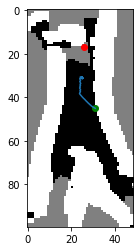

In [23]:
# define start and goal locations on a grid
start = (np.array([robot_pose[1], robot_pose[0]]) - [y_min, x_min]) // map_res
while True:
    i,j = np.random.randint(0, grid.shape[0]), np.random.randint(0, grid.shape[1])
    if grid[i,j] != 1:
        goal = [j, i]
        break
# goal = [20, 10]

# plan a path on a grid
path_grid = apf_planner(grid, start, goal)
path_grid = np.array(path_grid)
plt.imshow(grid, cmap='gray')
plt.plot(goal[0], goal[1], 'ro')
plt.plot(start[0], start[1], 'ro', color='g')
plt.plot(path_grid[:,0], path_grid[:,1])

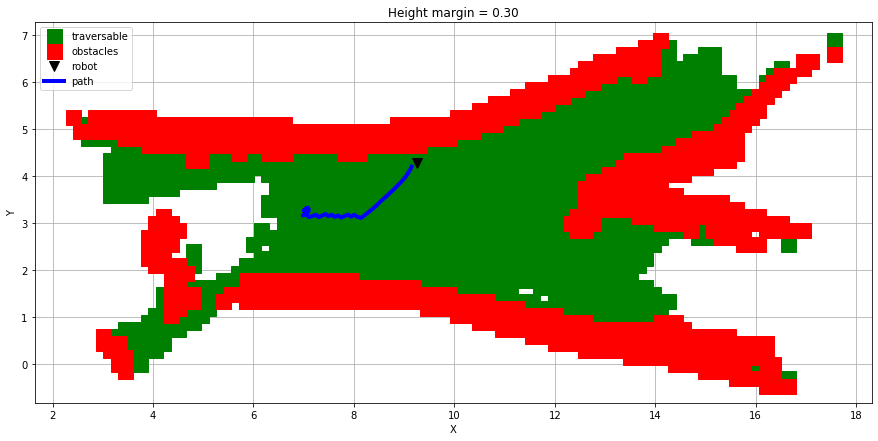

In [24]:
# convert to map coordinates
path_map = apf_path_to_map(path_grid, elev_map, elev_grid)

# visualize everithing
X = elev_map[:,0]; Y = elev_map[:,1]; Z = elev_map[:,2]
plt.figure(figsize=(int(np.max(X)-np.min(X)), int(np.max(Y)-np.min(Y))))
plt.plot(X[Z<=margin], Y[Z<=margin], 's', color='green', label='traversable', markersize=15)
plt.plot(X[Z>margin], Y[Z>margin], 's', color='red', label='obstacles', markersize=15)
plt.plot(robot_pose[0], robot_pose[1], 'v', color='k', markersize=10, label='robot')
path_map = np.array(path_map)
plt.plot(path_map[:,0], path_map[:,1], color='b', linewidth=4, label='path')

plt.title('Height margin = %.2f'%margin)
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.grid()
plt.show()

In [25]:
def grid_to_map(point, elev_map, elev_grid, map_res=0.15):
    x_min, y_min = np.min(elev_map[:, 0]), np.min(elev_map[:, 1])
    z = elev_grid[int(point[0]), int(point[1])]
    return (np.array(point)*map_res+[x_min, y_min]).tolist() + [z]

Found a frontier.
Path planning took 0.11923360824584961 sec


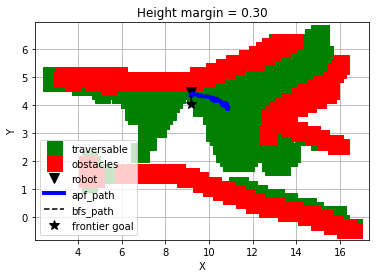

Found a frontier.
Path planning took 0.1962447166442871 sec


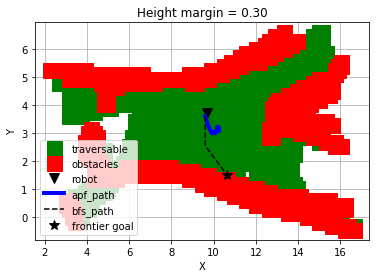

Found a frontier.
Path planning took 0.24819493293762207 sec


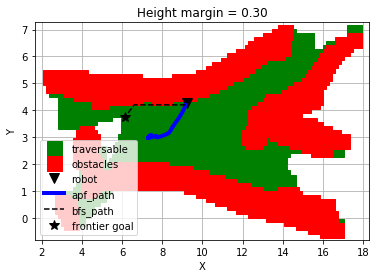

Found a frontier.
Path planning took 0.24987435340881348 sec


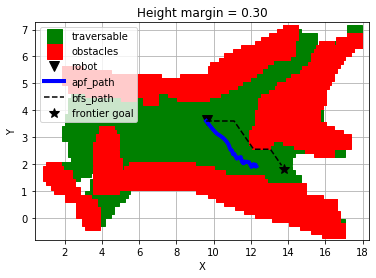

Found a frontier.
Path planning took 0.2608211040496826 sec


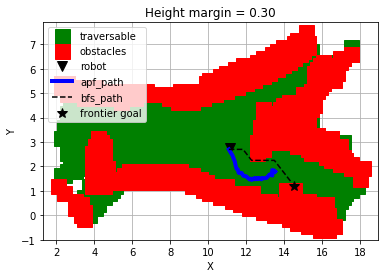

Found a frontier.
Path planning took 0.2610492706298828 sec


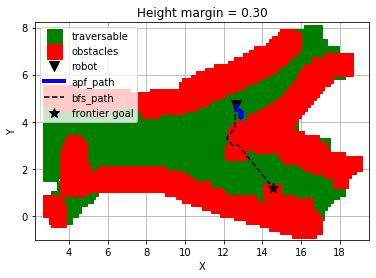

Found a frontier.
Path planning took 0.263427734375 sec


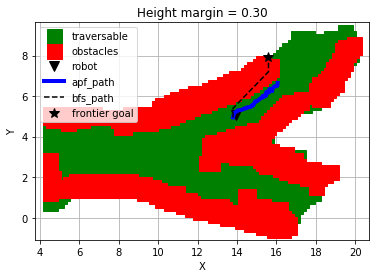

Found a frontier.
Path planning took 0.26053476333618164 sec


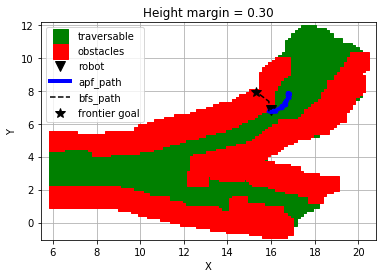

Found a frontier.
Path planning took 0.2724170684814453 sec


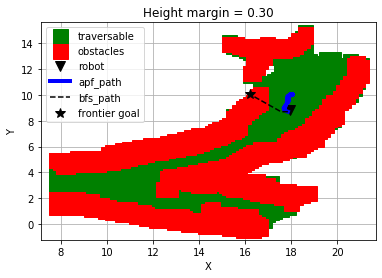

Found a frontier.
Path planning took 0.31519079208374023 sec


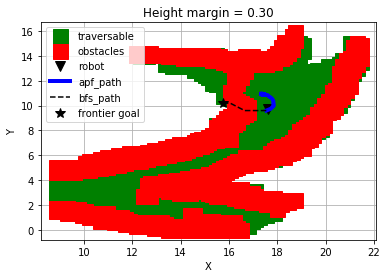

Found a frontier.
Path planning took 0.3227541446685791 sec


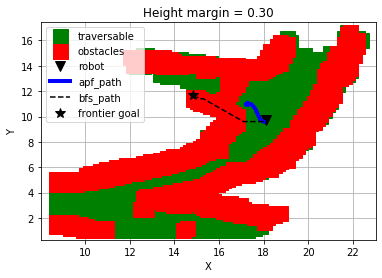

Found a frontier.
Path planning took 0.33709120750427246 sec


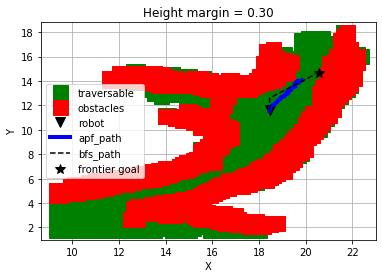

Found a frontier.
Path planning took 0.3090994358062744 sec


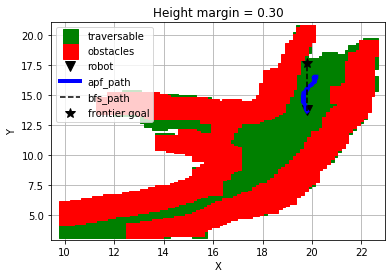

In [28]:
for ind in range(6, 19):
    # read data
    elev_map = np.load('./data/elev_map{}.npy'.format(ind))
    dynamic_pc = np.load('./data/dynamic_pc{}.npy'.format(ind))
    robot_pose = np.load('./data/robot_pose{}.npy'.format(ind))
    # elev_map = dynamic_pc

    tic = time.time()
    grid, elev_grid = create_grid(elev_map, map_res=map_res, safety_distance=0., margin=margin)
    x_min, y_min = np.min(elev_map[:, 0]), np.min(elev_map[:, 1])

    # define start on a grid
    robot_grid_pose = (robot_pose - [x_min, y_min, 0]) // map_res
    start_grid = (int(robot_grid_pose[0]), int(robot_grid_pose[1]))

    bfs_path_grid, goal_grid = breadth_first_search(grid, start_grid)
    # compute APF path on a grid
    apf_path_grid = apf_planner(grid, [start_grid[1], start_grid[0]], [goal_grid[1], goal_grid[0]], num_iters=50)
    # transform path to map coordintes (m)
    apf_path = apf_path_to_map(apf_path_grid, elev_map, elev_grid)
    print('Path planning took {} sec'.format(time.time()-tic))
    
    # BFS path
    # transform path to map coordintes (m)
    bfs_path = [(np.array(point)*0.15+[x_min, y_min]).tolist()+[elev_grid[point]] for point in bfs_path_grid]
    bfs_path = np.array(bfs_path)
    
    # visualize everithing
    X = elev_map[:,0]; Y = elev_map[:,1]; Z = elev_map[:,2]
    #plt.figure(figsize=(int(np.max(X)-np.min(X)), int(np.max(Y)-np.min(Y))))
    plt.plot(X[Z<=margin], Y[Z<=margin], 's', color='green', label='traversable', markersize=15)
    plt.plot(X[Z>margin], Y[Z>margin], 's', color='red', label='obstacles', markersize=15)
    plt.plot(robot_pose[0], robot_pose[1], 'v', color='k', markersize=10, label='robot')
    path = np.array(apf_path)
    plt.plot(path[:,0], path[:,1], color='b', linewidth=4, label='apf_path')
    plt.plot(bfs_path[:,0], bfs_path[:,1], '--', color='k', label='bfs_path')
    frontier_goal = grid_to_map(goal_grid, elev_map, elev_grid)
    plt.plot(frontier_goal[0], frontier_goal[1], '*', markersize=10, color='k', label='frontier goal')

    plt.title('Height margin = %.2f'%margin)
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.legend()
    plt.grid()
    plt.show()